In [1]:
import pandas as pd
%matplotlib inline
import geopandas as gp

https://www.cnn.com/2015/04/27/us/baltimore-unrest/index.html

In [83]:
df = pd.read_csv('raw/BPD_Part_1_Victim_Based_Crime_Data.csv').fillna('NaN')

# crime type

In [4]:
merge_type = {'LARCENY': 'THEFT', 
 'COMMON ASSAULT': 'ASSAULT', 
 'BURGLARY' : 'BURGLARY', 
 'LARCENY FROM AUTO': 'THEFT',
 'AUTO THEFT': 'THEFT', 
 'AGG. ASSAULT': 'ASSAULT', 
 'ROBBERY - STREET': 'ROBBERY',
 'ROBBERY - COMMERCIAL': 'ROBBERY', 
 'ASSAULT BY THREAT': 'ASSAULT', 
 'SHOOTING': 'SHOOTING',
 'ROBBERY - RESIDENCE': 'ROBBERY', 
 'ROBBERY - CARJACKING': 'ROBBERY', 
 'RAPE': 'RAPE', 
 'HOMICIDE': 'HOMICIDE',
 'ARSON': 'ARSON'}

simplified_types = ['THEFT', 'ASSAULT', 'BURGLARY', 'ROBBERY', 'SHOOTING', 'RAPE', 'HOMICIDE', 'ARSON']

In [5]:
df['simplified_type'] = df.Description.apply(lambda x: merge_type[x])

In [6]:
df.groupby('simplified_type').apply(lambda x: x.Description.value_counts()).to_frame()

Description
simplified_type                                  
ARSON           ARSON                        1319
ASSAULT         COMMON ASSAULT              39942
                AGG. ASSAULT                25049
                ASSAULT BY THREAT            3106
BURGLARY        BURGLARY                    38298
HOMICIDE        HOMICIDE                     1479
RAPE            RAPE                         1500
ROBBERY         ROBBERY - STREET            16814
                ROBBERY - COMMERCIAL         4101
                ROBBERY - RESIDENCE          2570
                ROBBERY - CARJACKING         1606
SHOOTING        SHOOTING                     2820
THEFT           LARCENY                     54369
                LARCENY FROM AUTO           31825
                AUTO THEFT                  25317

In [7]:
df.simplified_type.value_counts()

THEFT       111511
ASSAULT      68097
BURGLARY     38298
ROBBERY      25091
SHOOTING      2820
RAPE          1500
HOMICIDE      1479
ARSON         1319
Name: simplified_type, dtype: int64

# grid distribution

In [75]:
from shapely.geometry import Point, box

from matplotlib.colors import LinearSegmentedColormap


In [9]:

def grid_line(mini, maxi, ngrid=10):
    delta = (maxi - mini) / ngrid
    return [(mini + i * delta, mini + (i + 1) * delta) for i in range(ngrid)]


def grid_area(w, s, e, n, ngrid=10):
    """
    grid area into ngrid^2 grids
    :param w, s, e, n,: the w, s, e, n (min_lon, min_lat, max_lon, max_lat) of the bound box
    :param ngrid: divide area into ngrid^2 grids
    :return: list of grid represented by bound box with s,w,n,e
    """
    grid_lat = grid_line(s, n, ngrid)
    grid_lon = grid_line(w, e, ngrid)
    grids = []
    for i in range(ngrid):
        for j in range(ngrid):
            si, ni = grid_lat[i]
            wj, ej = grid_lon[j]
            grids.append((wj, si, ej, ni))
    return grids

In [10]:
cityline = gp.read_file('raw/Baltcity_Line/baltcity_line.shp')
cityline.to_crs(epsg=3559, inplace=True)

In [11]:
print('longitude, latitude')
cityline.to_crs(epsg=4326)

longitude, latitude


,AREA,BOUNDARY_,BOUNDARY_I,ID,LENGTH,PERIMETER,Shape_Leng,geometry
0,2.562713e+09,2.0,0.0,0.0,207126.513,207126.51563,207126.513062,LINESTRING (-76.7112936699702 39.3719570306727...


In [12]:
gpdf_crime = df[['Longitude', 'Latitude', 'simplified_type']]
gpdf_crime = gpdf_crime[gpdf_crime.Longitude!='NaN']
gpdf_crime['geometry'] = gpdf_crime.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
gpdf_crime = gp.GeoDataFrame(gpdf_crime.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'})
gpdf_crime.to_crs(cityline.crs, inplace=True)

In [35]:
line = cityline.geometry[0]
grids = grid_area(*line.bounds, ngrid=30)
wsen_poly = [box(*grid) for grid in grids]
wsen_poly = gp.GeoDataFrame(wsen_poly,columns=['geometry'], crs=cityline.crs)

In [36]:
joined = gp.sjoin(gpdf_crime, wsen_poly)

In [40]:
wsen_poly = wsen_poly.join(joined.groupby('index_right').agg({'simplified_type': 'count'}).rename(columns={'simplified_type':'ALL'}), how='inner')

In [42]:
col = 'simplified_type'
for t in simplified_types:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({'simplified_type': 'count'}).rename(columns={'simplified_type':t}))

In [45]:
wsen_poly.fillna(0, inplace=True)

In [49]:
from matplotlib import pyplot

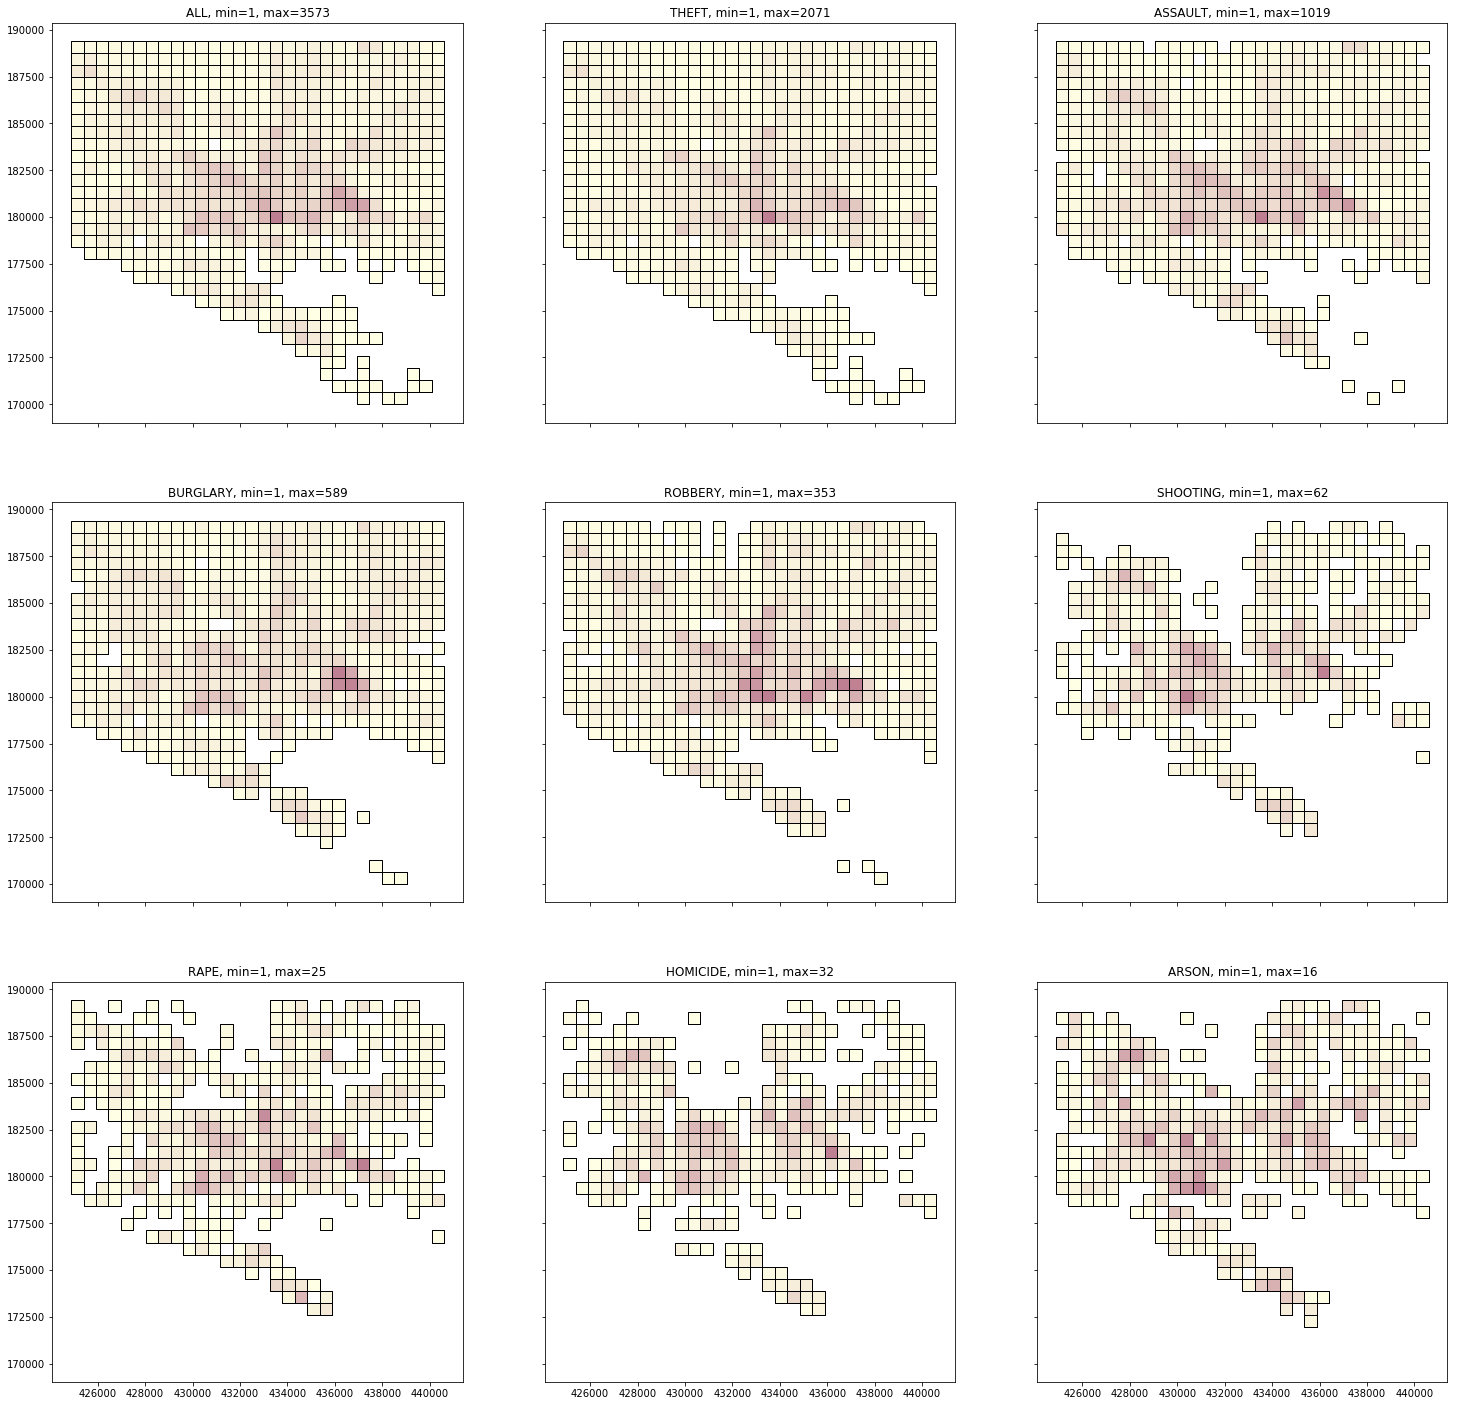

In [89]:

cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#ffffcc'), (1, '#800026')])
fig, axes = pyplot.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(25, 25))
for i, t in enumerate(['ALL'] + simplified_types):
    print(t, int(i/3), i%3)
    ax = axes[int(i/3)][i%3]
    mini, maxi = wsen_poly[wsen_poly[t]>0][t].min(), wsen_poly[t].max()
    ax.set_title('%s, min=%d, max=%d' % (t, mini, maxi))
    wsen_poly[wsen_poly[t]>0].plot(column=t, cmap=cmap, ax=ax, figsize=(9,9))
    

# time series

In [84]:
df_temp_series = pd.DataFrame(index=pd.date_range("2013-01-01", "2018-02-17"))

In [85]:
df_temp_series = df_temp_series.join(df.groupby('CrimeDate').agg({'Total Incidents': 'sum'}).rename(columns={'Total Incidents':'ALL'}))

In [81]:
col = 'simplified_type'
for t in ['THEFT', 'ASSAULT', 'BURGLARY', 'ROBBERY', 'SHOOTING',
       'RAPE', 'HOMICIDE', 'ARSON']:
    df_temp_series = df_temp_series.join(
        df[df[col]==t].groupby('CrimeDate').agg({'Total Incidents': 'sum'}).rename(columns={'Total Incidents':t}))

time series


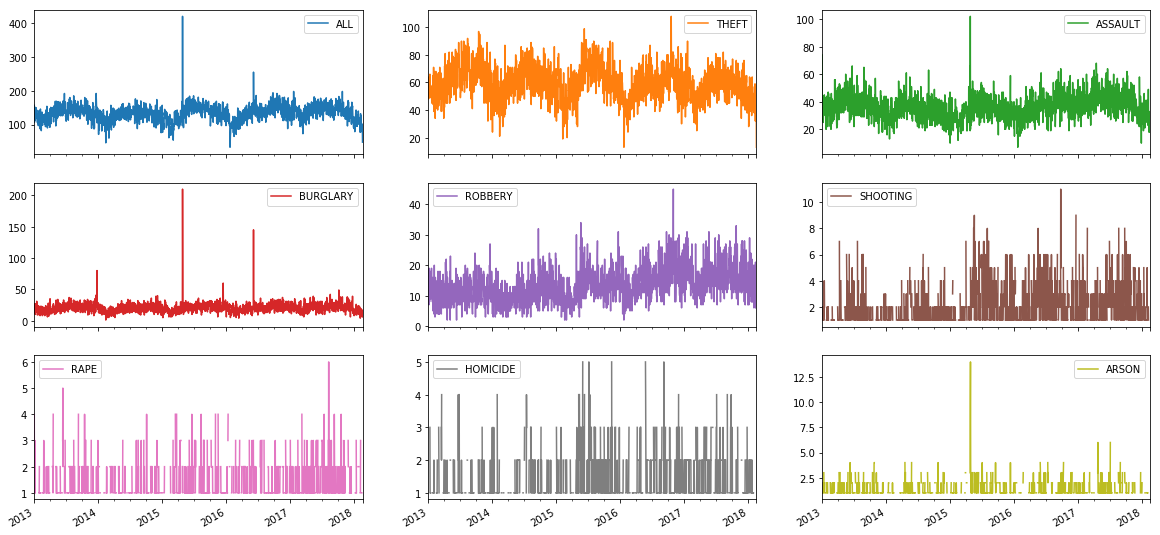

In [82]:
df_temp_series.plot(subplots=True, layout=(3,3), figsize=(20,10))
print('time series')

# understand CrimeCode

In [60]:
df.groupby('CrimeCode').apply(lambda x: x.Description.unique().__len__()).value_counts()

1    81
dtype: int64

In [61]:
d = df.groupby('Description').apply(lambda x: x.CrimeCode.unique().__len__()).value_counts().to_dict()
s=0
for k, v in d.items():
    s+=k*v
print(s)

81


In [66]:
d = df.groupby(['Description', 'Weapon', 'Total Incidents']).apply(lambda x: x.CrimeCode.unique().__len__()).value_counts().to_dict()
s=0
for k, v in d.items():
    s+=k*v
print(s)

81


In [63]:
d = df.groupby(['Description', 'Weapon']).apply(lambda x: x.CrimeCode.unique().__len__()).value_counts().to_dict()
s=0
for k, v in d.items():
    s+=k*v
print(s)

81


In [71]:
print(df.groupby(['Description', 'Weapon']).apply(lambda x: ', '.join(x.CrimeCode.unique())).to_csv())

AGG. ASSAULT,FIREARM,4A
AGG. ASSAULT,HANDS,4D
AGG. ASSAULT,KNIFE,4B
AGG. ASSAULT,OTHER,4C
ARSON,NaN,"8BO, 8GO, 8AO, 8J, 8H, 8FO, 8EO, 8AV, 8CV, 8FV, 8BV, 8DO, 8CO, 8GV, 8I, 8EV"
ASSAULT BY THREAT,NaN,4F
AUTO THEFT,NaN,"7A, 7C, 7B"
BURGLARY,NaN,"5A, 5D, 5C, 5E, 5B, 5F"
COMMON ASSAULT,HANDS,4E
HOMICIDE,FIREARM,1F
HOMICIDE,KNIFE,1K
HOMICIDE,OTHER,1O
LARCENY,NaN,"6G, 6E, 6B, 6C, 6J, 6L, 6F, 6A, 6H, 6K"
LARCENY FROM AUTO,NaN,6D
RAPE,NaN,2B
RAPE,OTHER,2A
ROBBERY - CARJACKING,FIREARM,3AJF
ROBBERY - CARJACKING,KNIFE,3AJK
ROBBERY - CARJACKING,NaN,3BJ
ROBBERY - CARJACKING,OTHER,3AJO
ROBBERY - COMMERCIAL,FIREARM,"3CF, 3GF, 3EF, 3LF"
ROBBERY - COMMERCIAL,KNIFE,"3CK, 3GK, 3LK, 3EK"
ROBBERY - COMMERCIAL,NaN,"3D, 3H, 3M, 3F"
ROBBERY - COMMERCIAL,OTHER,"3LO, 3CO, 3EO, 3GO"
ROBBERY - RESIDENCE,FIREARM,3JF
ROBBERY - RESIDENCE,KNIFE,3JK
ROBBERY - RESIDENCE,NaN,3K
ROBBERY - RESIDENCE,OTHER,3JO
ROBBERY - STREET,FIREARM,"3AF, 3NF"
ROBBERY - STREET,KNIFE,"3AK, 3NK"
ROBBERY - STREET,NaN,"3B, 3P"
ROBBERY - STR

In [70]:
print(df.groupby('Description').apply(lambda x: ', '.join(x.CrimeCode.unique())).to_csv())

AGG. ASSAULT,"4C, 4B, 4A, 4D"
ARSON,"8BO, 8GO, 8AO, 8J, 8H, 8FO, 8EO, 8AV, 8CV, 8FV, 8BV, 8DO, 8CO, 8GV, 8I, 8EV"
ASSAULT BY THREAT,4F
AUTO THEFT,"7A, 7C, 7B"
BURGLARY,"5A, 5D, 5C, 5E, 5B, 5F"
COMMON ASSAULT,4E
HOMICIDE,"1F, 1O, 1K"
LARCENY,"6G, 6E, 6B, 6C, 6J, 6L, 6F, 6A, 6H, 6K"
LARCENY FROM AUTO,6D
RAPE,"2B, 2A"
ROBBERY - CARJACKING,"3AJF, 3AJK, 3AJO, 3BJ"
ROBBERY - COMMERCIAL,"3D, 3CF, 3GF, 3H, 3CK, 3GK, 3EF, 3LO, 3CO, 3LK, 3M, 3LF, 3F, 3EO, 3EK, 3GO"
ROBBERY - RESIDENCE,"3JO, 3K, 3JF, 3JK"
ROBBERY - STREET,"3AF, 3B, 3AO, 3AK, 3NO, 3P, 3NF, 3NK, 3N"
SHOOTING,9S



In [51]:
df.groupby(['Description', 'Weapon', 'CrimeCode']).count()

CrimeDate  CrimeTime  Location  \
Description          Weapon  CrimeCode                                   
AGG. ASSAULT         FIREARM 4A              5573       5573      5557   
                     HANDS   4D              3078       3078      3039   
                     KNIFE   4B              6114       6114      6057   
                     OTHER   4C             10284      10284     10176   
COMMON ASSAULT       HANDS   4E             39942      39942     39562   
HOMICIDE             FIREARM 1F              1246       1246      1246   
                     KNIFE   1K               135        135       135   
                     OTHER   1O                98         98        98   
RAPE                 OTHER   2A              1344       1344      1341   
ROBBERY - CARJACKING FIREARM 3AJF            1121       1121      1103   
                     KNIFE   3AJK              82         82        81   
                     OTHER   3AJO              85         85        85   
ROBBERY - COMMERCIAL FIREARM 3CF             2020       2020      2014   
                             3EF               70         70        69   
                             3GF              267        267       266   
                             3LF               31         31        31   
                     KNIFE   3CK              333        333       331   
                             3EK               17         17        17   
                             3GK               56         56        56   
                             3LK                2          2         2   
                     OTHER   3CO              252        252       250   
                             3EO               13         13        13   
                             3GO               31         31        31   
                             3LO               17         17        17   
ROBBERY - RESIDENCE  FIREARM 3JF              832        832       825   
                     KNIFE   3JK              189        189       189   
                     OTHER   3JO              169        169       169   
ROBBERY - STREET     FIREARM 3AF             7564       7564      7484   
                             3NF              228        228       226   
                     KNIFE   3AK             1610       1610      1580   
                             3NK               61         61        59   
                     OTHER   3AO             1136       1136      1116   
                             3N                 5          5         5   
                             3NO               44         44        42   
SHOOTING             FIREARM 9S              2820       2820      2817   

                                        Inside/Outside   Post  District  \
Description          Weapon  CrimeCode                                    
AGG. ASSAULT         FIREARM 4A                   5131   5570      5573   
                     HANDS   4D                   2914   3077      3077   
                     KNIFE   4B                   5725   6108      6112   
                     OTHER   4C                   9512  10273     10277   
COMMON ASSAULT       HANDS   4E                  37527  39906     39921   
HOMICIDE             FIREARM 1F                   1246   1246      1246   
                     KNIFE   1K                    135    135       135   
                     OTHER   1O                     98     98        98   
RAPE                 OTHER   2A                   1226   1344      1344   
ROBBERY - CARJACKING FIREARM 3AJF                 1005   1117      1120   
                     KNIFE   3AJK                   77     82        82   
                     OTHER   3AJO                   78     85        85   
ROBBERY - COMMERCIAL FIREARM 3CF                  1886   2018      2019   
                             3EF                    60     70        70   
                             3GF                   254    267       267   
                          